<a href="https://colab.research.google.com/github/ftavella/when_should_school_start/blob/main/When_Should_School_Start%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
!pip install astral
!pip install timezonefinder
!pip uninstall -y circadian
!pip install --upgrade git+https://github.com/ftavella/circadian.git@school_light_schedule

Found existing installation: circadian 1.0.2
Uninstalling circadian-1.0.2:
  Successfully uninstalled circadian-1.0.2
  Cloning https://github.com/ftavella/circadian.git (to revision school_light_schedule) to /tmp/pip-req-build-xqprt2xk
  Running command git clone --filter=blob:none --quiet https://github.com/ftavella/circadian.git /tmp/pip-req-build-xqprt2xk
  Running command git checkout -b school_light_schedule --track origin/school_light_schedule
  Switched to a new branch 'school_light_schedule'
  branch 'school_light_schedule' set up to track 'origin/school_light_schedule'.
  Resolved https://github.com/ftavella/circadian.git to commit 6e53092fd5e524d9748c490ca40ae140f00fbc61
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for circadian: filename=circadian-1.0.2-py3-none-any.whl size=46659 sha256=aa4c0736f7a559fba2ed6132e34c0773c0e49732cd3d0fe279b67254872880df
  Stored in direct

In [ ]:
import pytz
import numpy as np
import pysolar as ps
from astral.sun import sun
from datetime import datetime
import matplotlib.pyplot as plt
from astral import LocationInfo
from geopy.geocoders import Nominatim
from timezonefinder import TimezoneFinder
from circadian.lights import LightSchedule
from circadian.models import Skeldon23, DynamicalTrajectory

In [ ]:
def circadian_modulation_of_sleep(model, trajectory):
    x = trajectory.states[:, 0]
    xc = trajectory.states[:, 1]
    linear_term = model.c20 + model.alpha21 * xc + model.alpha22 * x
    quadratic_term = model.beta21 * xc * xc + model.beta22 * xc * x + model.beta23 * x * x
    C = linear_term + quadratic_term
    return C


def H_thresholds(model, trajectory):
    C = circadian_modulation_of_sleep(model, trajectory)
    H_plus = model.H0 + 0.5 * model.Delta + model.ca * C
    H_minus = model.H0 - 0.5 * model.Delta + model.ca * C 
    return H_plus, H_minus


def calculate_sleep_onset_and_offset(time, sleep):
    sleep_onset_idx = np.where(np.diff(sleep) == 1)[0]
    sleep_offset_idx = np.where(np.diff(sleep) == -1)[0]
    if sleep_offset_idx[0] < sleep_onset_idx[0]:
        sleep_offset_idx = sleep_offset_idx[1:]
    if sleep_onset_idx[-1] > sleep_offset_idx[-1]:
        sleep_onset_idx = sleep_onset_idx[:-1]
    min_length = min(len(sleep_onset_idx), len(sleep_offset_idx))
    sleep_onset_idx = sleep_onset_idx[:min_length]
    sleep_offset_idx = sleep_offset_idx[:min_length]
    return time[sleep_onset_idx], time[sleep_offset_idx]


def calculate_sleep_duration(time, sleep):
    sleep_onset, sleep_offset = calculate_sleep_onset_and_offset(time, sleep)
    sleep_duration = sleep_offset - sleep_onset
    return sleep_duration


def get_city_info(city_name):
    """
    Gets the latitude, longitude, and time zone of a given city.

    Args:
        city_name: The name of the city.

    Returns:
        A dictionary containing the latitude, longitude, and time zone of the city,
        or None if the city is not found or an error occurs.
    """
    geolocator = Nominatim(user_agent="app")
    tf = TimezoneFinder()

    try:
        location = geolocator.geocode(city_name)
        if location:
            latitude = location.latitude
            longitude = location.longitude
            timezone = tf.timezone_at(lng=longitude, lat=latitude)

            return {
                "latitude": latitude,
                "longitude": longitude,
                "timezone": timezone,
            }
        else:
            print(f"City '{city_name}' not found.")
            return None
    except Exception as e:
        print(f"Error getting city info: {e}")
        return None


def get_sunrise_sunset(latitude, longitude, timezone, datetime_value):
    """
    Calculates sunrise and sunset times for a given latitude, longitude, and timezone.

    Args:
        latitude: Latitude of the location.
        longitude: Longitude of the location.
        timezone: Timezone string (e.g., "US/Pacific", "Europe/London").

    Returns:
        A tuple containing sunrise and sunset times as hours of the day in local time,
        or None if an error occurs.
    """
    try:
        # Create a LocationInfo object with the specified timezone
        city = LocationInfo("Example City", "Region", timezone, latitude, longitude)

        # Calculate sunrise and sunset for today
        s = sun(city.observer, date=datetime_value)

        # Convert sunrise and sunset to local time
        local_tz = pytz.timezone(timezone)
        sunrise_local = s['sunrise'].astimezone(local_tz)
        sunset_local = s['sunset'].astimezone(local_tz)

        # Extract hour of day
        sunrise_hour = sunrise_local.hour
        sunset_hour = sunset_local.hour

        return sunrise_hour, sunset_hour

    except Exception as e:
        print(f"Error calculating sunrise/sunset: {e}")
        return None, None


def get_direct_sunlight_lux(datetime_value, timezone, latitude, longitude,
                            wm2_to_lux_conversion_factor=120):
    """
    Calculates the direct sunlight illuminance (lux) at a given location and time.

    Args:
        date: The date and time for which to calculate the illuminance.
        timezone: The timezone of the location.
        latitude: The latitude of the location.
        longitude: The longitude of the location.

    Returns:
        The direct sunlight illuminance in lux, or None if an error occurs.
    """
    try:
        timezone_aware_datetime = pytz.timezone(timezone).localize(datetime_value)
        # Get the solar elevation angle for the location and time
        altitude_deg = ps.solar.get_altitude(latitude, longitude, timezone_aware_datetime)
        # Calculate the illuminance in lux
        illuminance = ps.solar.radiation.get_radiation_direct(datetime_value, altitude_deg)
        lux = illuminance * wm2_to_lux_conversion_factor  # Convert W/m^2 to lux
        return lux

    except Exception as e:
        print(f"Error calculating direct sunlight lux: {e}")
        return None


def get_outdoor_light_parameters(city_name, datetime_value, dst_in_effect):
    location_dict = get_city_info(city_name)
    if location_dict is None:
        return None
    else:
        latitude = location_dict["latitude"]
        longitude = location_dict["longitude"]
        timezone = location_dict["timezone"]

        # Get sunrise and sunset times
        sunrise_hour, sunset_hour = get_sunrise_sunset(latitude, longitude, timezone, datetime_value)
        if sunrise_hour is None or sunset_hour is None:
            return None

        direct_sunlight_lux = get_direct_sunlight_lux(datetime_value, timezone, latitude, longitude) # Adjust for DST?

        if dst_in_effect:
            # Adjust for daylight saving time
            sunrise_hour += 1
            sunset_hour += 1

        return {
            "latitude": latitude,
            "longitude": longitude,
            "timezone": timezone,
            "sunrise_hour": sunrise_hour,
            "sunset_hour": sunset_hour,
            "direct_sunlight_lux": direct_sunlight_lux,
        }

# Getting light parameters

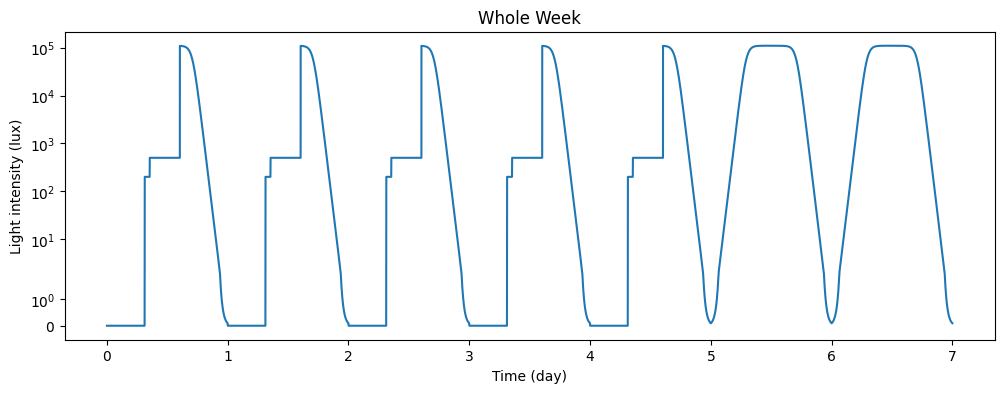

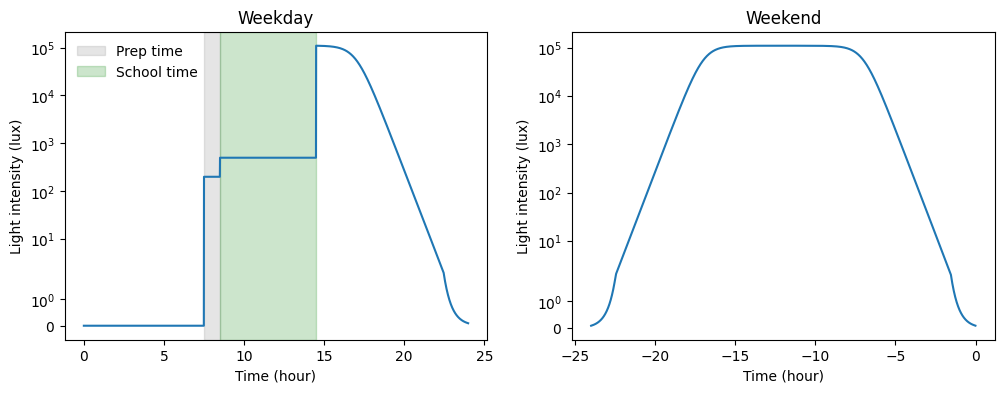

In [181]:
dt = 0.01 # hours
weeks = 1
school_start_time = 8.5
school_duration = 6.0
prep_time = 1.0
location = "New York"
datetime_value = datetime.strptime("2022-01-21 13:00:00", "%Y-%m-%d %H:%M:%S")
dst_in_effect = datetime_value.dst()
lux_params = get_outdoor_light_parameters(location, datetime_value, dst_in_effect)

time = np.arange(0, 24*7*weeks, dt)

light_schedule_parameters = {
    'school_start_time': school_start_time,
    'school_prep_duration': prep_time,
    'school_duration': school_duration,
    'outdoor_peak_lux': lux_params["direct_sunlight_lux"],
    'outdoor_light_sunrise_time': lux_params["sunrise_hour"],
    'outdoor_light_sunset_time': lux_params["sunset_hour"],
}

school_schedule = LightSchedule.School(**light_schedule_parameters)
school_light = school_schedule(time)

weekday_mask = (time >= 0) & (time < 24)
wekkend_mask = (time >= 24*5) & (time < 24*6)

whole_week_fig = plt.figure(figsize=(12, 4))
whole_week_ax = whole_week_fig.add_subplot(111)
whole_week_ax.plot(time / 24.0, school_light, label='School Light Schedule')
whole_week_ax.set_yscale('symlog')
whole_week_ax.set_xlabel('Time (day)')
whole_week_ax.set_ylabel('Light intensity (lux)')
whole_week_ax.set_title('Whole Week')

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(time[weekday_mask], school_light[weekday_mask])
ax[0].set_yscale('symlog')
ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Light intensity (lux)')
ax[0].set_title('Weekday')
ax[0].axvspan(school_start_time - prep_time, school_start_time, color='gray', alpha=0.2,
              edgecolor=None, label='Prep time')
ax[0].axvspan(school_start_time, school_start_time + school_duration, color='green', alpha=0.2,
              edgecolor=None, label='School time')
ax[0].legend(frameon=False)

ax[1].plot(time[wekkend_mask] - 24 * 6, school_light[wekkend_mask], label='Weekend')
ax[1].set_yscale('symlog')
ax[1].set_xlabel('Time (hour)')
ax[1].set_ylabel('Light intensity (lux)')
ax[1].set_title('Weekend')

plt.show()


# Running a single simulation

In [ ]:
dt = 0.01 # hours
weeks = 4
school_start_time = 8.5
school_duration = 6.0
prep_time = 1.0
location = "New York"
datetime_value = datetime.strptime("2022-01-21 13:00:00", "%Y-%m-%d %H:%M:%S")
dst_in_effect = datetime_value.dst()
lux_params = get_outdoor_light_parameters(location, datetime_value, dst_in_effect)

time = np.arange(0, 24*7*weeks, dt)

light_schedule_parameters = {
    'school_start_time': school_start_time,
    'school_prep_duration': prep_time,
    'school_duration': school_duration,
    'outdoor_peak_lux': lux_params["direct_sunlight_lux"],
    'outdoor_light_sunrise_time': lux_params["sunrise_hour"],
    'outdoor_light_sunset_time': lux_params["sunset_hour"],
}

school_schedule = LightSchedule.School(**light_schedule_parameters)
school_light = school_schedule(time)

parameters = {
        'S0': 0,
        'forced_wakeup_light_threshold': 100.0, # half the default prep time lux
        'forced_wakeup_weekday_only': True,
}

model = Skeldon23(params=parameters)
trajectory = model.integrate(time, input=school_light)

In [190]:
sleep = model.sleep_state
circadian_state = trajectory.states[:, 0]
sleep_homeostat = trajectory.states[:, 3]
H_plus, H_minus = H_thresholds(model, trajectory)

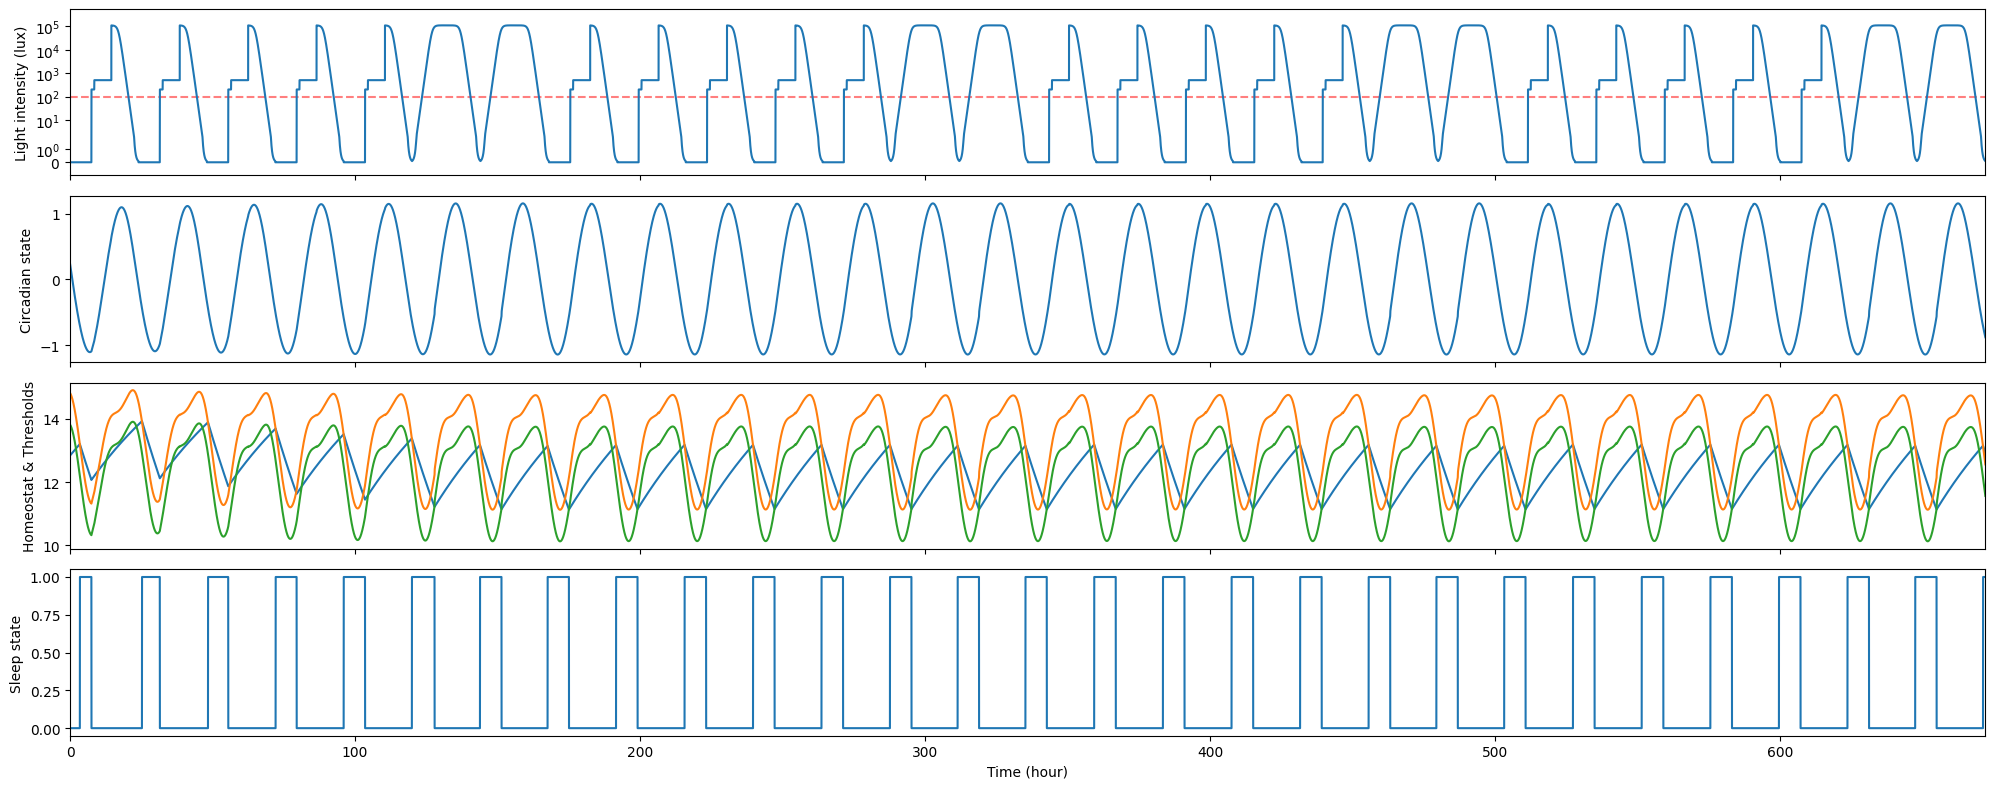

In [195]:
fig, ax = plt.subplots(4, 1, figsize=(20, 8), sharex=True)

ax[0].plot(time, school_light, label='Light')
ax[0].axhline(model.forced_wakeup_light_threshold, color='r', linestyle='--', label='Forced wakeup threshold', 
              alpha=0.5, zorder=-1)
ax[0].set_yscale('symlog')
ax[0].set_ylim(-1, 5.0 * lux_params["direct_sunlight_lux"])
ax[0].set_xlim(0, 24*7*weeks)
ax[0].set_ylabel('Light intensity (lux)')

ax[1].plot(time, circadian_state, label='Circadian state')
ax[1].set_ylabel('Circadian state')

ax[2].plot(time, sleep_homeostat, label='Sleep homeostat')
ax[2].plot(time, H_plus, label='H+')
ax[2].plot(time, H_minus, label='H-')
ax[2].set_ylabel('Homeostat & Thresholds')

ax[3].plot(time, sleep, label='Sleep state')
ax[3].set_ylabel('Sleep state')
ax[3].set_xlabel('Time (hour)')

plt.tight_layout()
plt.show()

# Multiple school start times

In [199]:
location = "New York"
datetime_value = datetime.strptime("2022-01-21 13:00:00", "%Y-%m-%d %H:%M:%S")
dst_in_effect = datetime_value.dst()
lux_params = get_outdoor_light_parameters(location, datetime_value, dst_in_effect)

school_start_times = np.array([6, 7, 8, 9, 10, 11, 12], dtype=float)

dt = 0.01 # hours
weeks = 4
school_start_time = 8.5
school_duration = 6.0
prep_time = 1.0

time = np.arange(0, 24*7*weeks, dt)

light_schedule_parameters = {
    'school_prep_duration': prep_time,
    'school_duration': school_duration,
    'outdoor_peak_lux': lux_params["direct_sunlight_lux"],
    'outdoor_light_sunrise_time': lux_params["sunrise_hour"],
    'outdoor_light_sunset_time': lux_params["sunset_hour"],
}

parameters = {
        'S0': 0,
        'forced_wakeup_light_threshold': 100.0, # half the default prep time lux
        'forced_wakeup_weekday_only': True,
}


results = {
    'model': [],
    'trajectory': [],
    'light': [],
    'sleep': [],
}

for school_start_time in school_start_times:
    print(f'School start time: {school_start_time}')
    school_schedule = LightSchedule.School(school_start_time=school_start_time,
                                           **light_schedule_parameters)
    # Equilibrate for two weeks
    equilibration_model = Skeldon23(params=parameters)
    equilibration_time = np.arange(0, 24*7, dt) # one week
    equilibration_light = school_schedule(equilibration_time)
    initial_condition = model.equilibrate(equilibration_time, equilibration_light,
                                          num_loops=2) # two loops
    # Simulate
    simulation_parameters = parameters.copy()
    simulation_parameters['S0'] = equilibration_model.sleep_state[-1]
    model = Skeldon23(params=simulation_parameters)
    school_light = school_schedule(time)
    trajectory = model.integrate(time, input=school_light, initial_condition=initial_condition)

    results['model'].append(model)
    results['trajectory'].append(trajectory)
    results['light'].append(school_light)
    results['sleep'].append(model.sleep_state)

School start time: 6.0


/home/arcascope/when_should_school_start/.venv/lib/python3.12/site-packages/circadian/models.py:431: UserWarning: The model did not equilibrate. Try increasing the number of loops.
  warnings.warn("The model did not equilibrate. Try increasing the number of loops.")


School start time: 7.0
School start time: 8.0
School start time: 9.0
School start time: 10.0
School start time: 11.0
School start time: 12.0


In [200]:
plot_each_solution = False

average_sleep_duration = []
average_sleep_weekday = []
average_sleep_weekend = []

for i, (model, trajectory, school_light, sleep) in enumerate(zip(results['model'], results['trajectory'], results['light'], results['sleep'])):
    print(f'School start time: {school_start_times[i]}')
    circadian_state = trajectory.states[:, 0]
    sleep_homeostat = trajectory.states[:, 3]
    H_plus, H_minus = H_thresholds(model, trajectory)

    # Calculate sleep metrics
    sleep_onset, sleep_offset = calculate_sleep_onset_and_offset(time, sleep)
    sleep_duration = calculate_sleep_duration(time, sleep)

    weekday_sleep_duration = []
    weekend_sleep_duration = []
    for idx, onset in enumerate(sleep_onset):
        if (onset / 24.0) % 7 < 5:
            weekday_sleep_duration.append(sleep_duration[idx])
        else:
            weekend_sleep_duration.append(sleep_duration[idx])

    average_sleep_duration.append(np.mean(sleep_duration))
    average_sleep_weekday.append(np.mean(weekday_sleep_duration))
    average_sleep_weekend.append(np.mean(weekend_sleep_duration))

    if plot_each_solution:
        fig, ax = plt.subplots(4, 1, figsize=(20, 8))#, sharex=True)

        ax[0].plot(time, school_light, label='Light')
        ax[0].axhline(model.forced_wakeup_light_threshold, color='r', linestyle='--', label='Forced wakeup threshold')
        ax[0].set_yscale('symlog')
        ax[0].set_ylim(-1, 2.0 * school_light.max())
        # ax[0].set_xlim(0, 24*7)
        # ax[0].set_xlim(24*7*weeks-24*7, 24*7*weeks)

        ax[1].plot(time, circadian_state, label='Circadian state')

        ax[2].plot(time, sleep_homeostat, label='Sleep homeostat')
        ax[2].plot(time, H_plus, label='H+')
        ax[2].plot(time, H_minus, label='H-')

        ax[3].plot(time, sleep, label='Sleep state')

        plt.tight_layout()
        plt.show()

School start time: 6.0
School start time: 7.0
School start time: 8.0
School start time: 9.0
School start time: 10.0
School start time: 11.0
School start time: 12.0


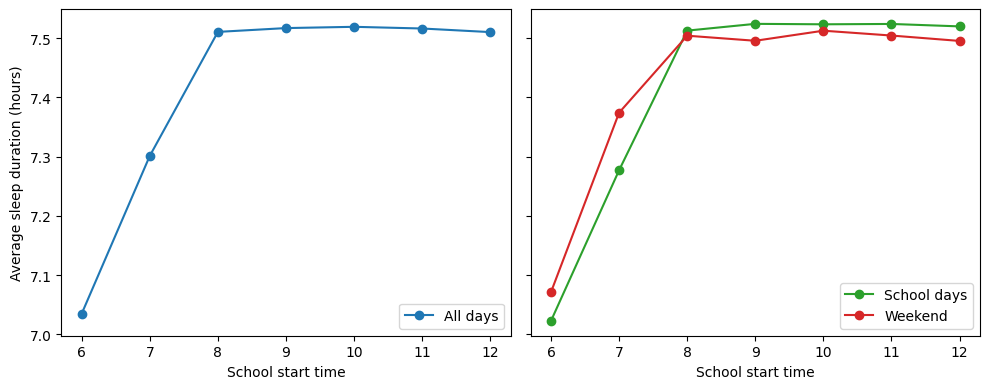

In [201]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)

ax[0].plot(school_start_times, average_sleep_duration, '-o', label='All days',
           color='tab:blue')
ax[0].set_xlabel('School start time')
ax[0].set_ylabel('Average sleep duration (hours)')
ax[0].legend(loc='lower right')

ax[1].plot(school_start_times, average_sleep_weekday, '-o', label='School days',
           color='tab:green')
ax[1].plot(school_start_times, average_sleep_weekend, '-o', label='Weekend',
           color='tab:red')
ax[1].set_xlabel('School start time')
ax[1].legend()

plt.tight_layout()
plt.show()

# Some results at different locations

## New York (2022-01-21 13:00:00)
![alt text](f0d4725a-bd4c-49a8-8955-0d1f471d3fd2.png)
![alt text](c6b1d1ed-6282-4426-93ed-ea56bcc029e6.png)

## Caracas (2022-07-21 13:00:00)

![alt text](c5006dcd-cf38-4dbd-89b4-62d02d5b995b.png)
![alt text](5c79171d-699b-4832-a67b-27f38573f6c3.png)

## Anchorage (2022-07-21 13:00:00)

![alt text](5b0110e9-82e5-4161-920d-0a7edf4bc48b.png)
![alt text](97ce5e35-d9de-4793-b0a7-dc601670312d.png)


# Old code

In [ ]:
%%capture

import numpy as np
import matplotlib.pyplot as plt
from circadian.lights import *
from circadian.sleep import *
from scipy.stats import circmean
from circadian.models import Skeldon23



def smooth_light(t):
    rise = np.tanh(0.6 * (t - 8.0))
    fall = np.tanh(0.6 * (t - 17.0))
    y = (700.0 / 2.0) * (rise - fall) + 40.0
    return y

schedule = LightSchedule(smooth_light, period=24.0)
dt = 0.01 # hours
days = 5
time = np.arange(8.0, 24 * days + 8.0, dt)
light = schedule(time)
model = Skeldon23()

# equilibrate model
initial_condition = model.equilibrate(time, light, num_loops=20)
# simulate model
trajectory = model(time, initial_condition=initial_condition, input=light)
sleep = model.sleep_state
received_light = model.received_light


# sleep start
sleep_start_idxs = np.where(np.diff(sleep) == 1)[0]
sleep_start_times = np.mod(time[sleep_start_idxs], 24.0)
avg_sleep_start = circmean(sleep_start_times, high=24.0)
# sleep end
sleep_end_idxs = np.where(np.diff(sleep) == -1)[0]
sleep_end_times = np.mod(time[sleep_end_idxs], 24.0)
avg_sleep_end = circmean(sleep_end_times, high=24.0)
# sleep duration
sleep_end_idxs = np.where(np.diff(sleep) == -1)[0]
sleep_duration = time[sleep_end_idxs] - time[sleep_start_idxs]

In [ ]:
%%capture

import numpy as np
import matplotlib.pyplot as plt
from circadian.lights import *
from circadian.sleep import *
from astral import LocationInfo
from astral.sun import sun
import datetime
import pytz


from geopy.geocoders import Nominatim
from timezonefinder import TimezoneFinder

def get_city_info(city_name):
    """
    Gets the latitude, longitude, and time zone of a given city.

    Args:
        city_name: The name of the city.

    Returns:
        A dictionary containing the latitude, longitude, and time zone of the city,
        or None if the city is not found or an error occurs.
    """
    geolocator = Nominatim(user_agent="my_app")  # Replace "my_app" with your application name
    tf = TimezoneFinder()

    try:
        location = geolocator.geocode(city_name)
        if location:
            latitude = location.latitude
            longitude = location.longitude
            timezone = tf.timezone_at(lng=longitude, lat=latitude)

            return {
                "latitude": latitude,
                "longitude": longitude,
                "timezone": timezone,
            }
        else:
            print(f"City '{city_name}' not found.")
            return None
    except Exception as e:
        print(f"Error getting city info: {e}")
        return None


def get_sunrise_sunset(latitude, longitude, timezone, day):
    """
    Calculates sunrise and sunset times for a given latitude, longitude, and timezone.

    Args:
        latitude: Latitude of the location.
        longitude: Longitude of the location.
        timezone: Timezone string (e.g., "US/Pacific", "Europe/London").

    Returns:
        A tuple containing sunrise and sunset times as hours of the day in local time,
        or None if an error occurs.
    """
    try:
        # Create a LocationInfo object with the specified timezone
        city = LocationInfo("Example City", "Region", timezone, latitude, longitude)

        # Calculate sunrise and sunset for today
        s = sun(city.observer, date=day)

        # Convert sunrise and sunset to local time
        local_tz = pytz.timezone(timezone)
        sunrise_local = s['sunrise'].astimezone(local_tz)
        sunset_local = s['sunset'].astimezone(local_tz)

        # Extract hour of day
        sunrise_hour = sunrise_local.hour
        sunset_hour = sunset_local.hour

        return sunrise_hour, sunset_hour

    except Exception as e:
        print(f"Error calculating sunrise/sunset: {e}")
        return None


def generate_light_function(latitude, longitude, timezone, day, dst_in_effect):
    """
    Generates a smooth light function based on location and time of year.
    """
    sunrise_hour, sunset_hour = get_sunrise_sunset(latitude, longitude, timezone, day)

    if sunrise_hour is None or sunset_hour is None:
      return None # Handle the case where sunrise/sunset calculation failed


    if dst_in_effect:
        sunrise_hour += 1
        sunset_hour += 1

    def light_function(t):
        rise = np.tanh(0.6 * (t - sunrise_hour))
        fall = np.tanh(0.6 * (t - sunset_hour))
        y = (700.0 / 2.0) * (rise - fall) + 40.0
        return y

    return light_function

day = datetime.date.today()
dst_in_effect = True

city_info = get_city_info("San Francisco")
if city_info:
  latitude = city_info["latitude"]
  longitude = city_info["longitude"]
  timezone = city_info["timezone"]

light_func = generate_light_function(latitude, longitude, timezone, day, dst_in_effect)

if light_func:
  # Test the function
  dt = 0.01  # hours
  days = 1
  time = np.arange(0, 24 * days, dt)
  light = light_func(time)

  plt.plot(time, light)
  plt.xlabel("Time (hours)")
  plt.ylabel("Light Intensity")
  plt.title(f"Light in {timezone} at {latitude} {longitude}")
  plt.show()
else:
  print("Failed to generate light function.")


In [ ]:

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import datetime

city_input = widgets.Text(description='City:', value='San Francisco')
date_picker = widgets.DatePicker(description='Date:', value=datetime.date.today())
dst_checkbox = widgets.Checkbox(value=True, description='DST in effect?')
plot_button = widgets.Button(description='Plot Light')

output = widgets.Output()


def plot_light(b):
    with output:
        clear_output(wait=True)  # Clear previous plot
        city_name = city_input.value
        selected_date = date_picker.value
        dst_in_effect = dst_checkbox.value

        city_info = get_city_info(city_name)
        if city_info:
            latitude = city_info["latitude"]
            longitude = city_info["longitude"]
            timezone = city_info["timezone"]

            light_func = generate_light_function(latitude, longitude, timezone, selected_date, dst_in_effect)

            if light_func:
                dt = 0.01  # hours
                days = 1
                time = np.arange(0, 24 * days, dt)
                light = light_func(time)

                plt.plot(time, light)
                plt.xlabel("Time (hours)")
                plt.ylabel("Light Intensity")
                plt.title(f"Light in {city_name} on {selected_date}")
                plt.show()
            else:
                print("Failed to generate light function.")
        else:
            print(f"Could not find information for city: {city_name}")



plot_button.on_click(plot_light)

display(city_input, date_picker, dst_checkbox, plot_button, output)


In [ ]:
# Franco
def generate_light_function(latitude, longitude, timezone, day, dst_in_effect):
    """
    Generates a smooth light function based on location and time of year.
    """
    sunrise_hour, sunset_hour = get_sunrise_sunset(latitude, longitude, timezone, day)
    print(f"Sunrise: {sunrise_hour} hrs, Sunset: {sunset_hour} hrs")

    if sunrise_hour is None or sunset_hour is None:
      return None # Handle the case where sunrise/sunset calculation failed


    if dst_in_effect:
        sunrise_hour += 1
        sunset_hour += 1

    def light_function(t):
        rise = np.tanh(0.6 * (t - sunrise_hour))
        fall = np.tanh(0.6 * (t - sunset_hour))
        y = (700.0 / 2.0) * (rise - fall) + 40.0
        return y

    return light_function
def circadian_modulation_of_sleep(model, trajectory):
    x = trajectory.states[:, 0]
    xc = trajectory.states[:, 1]
    linear_term = model.c20 + model.alpha21 * xc + model.alpha22 * x
    quadratic_term = model.beta21 * xc * xc + model.beta22 * xc * x + model.beta23 * x * x
    C = linear_term + quadratic_term
    return C

def H_thresholds(model, trajectory):
    C = circadian_modulation_of_sleep(model, trajectory)
    H_plus = model.H0 + 0.5 * model.Delta + model.ca * C
    H_minus = model.H0 - 0.5 * model.Delta + model.ca * C
    return H_plus, H_minus

def calculate_average_sleep_start(time, sleep):
    sleep_onset_idx = np.where(np.diff(sleep) == 1)[0]
    sleep_onset_time = np.mod(time[sleep_onset_idx][:-1], 24.0)
    average_sleep_onset = circmean(sleep_onset_time, high=24.0)
    return average_sleep_onset

def calculate_average_sleep_end(time, sleep):
    sleep_offset_idx = np.where(np.diff(sleep) == -1)[0]
    sleep_offset_time = np.mod(time[sleep_offset_idx][:-1], 24.0)
    average_sleep_offset = circmean(sleep_offset_time, high=24.0)
    return average_sleep_offset

def calculate_average_sleep_duration(time, sleep):
    if sleep[0] == 1:
        sleep_offset_idx = np.where(np.diff(sleep) == -1)[0][1:] # ignore first offset
    else:
        sleep_offset_idx = np.where(np.diff(sleep) == -1)[0]
    if sleep[-1] == 1:
        sleep_onset_idx = np.where(np.diff(sleep) == 1)[0][:-1] # ignore last onset
    else:
        sleep_onset_idx = np.where(np.diff(sleep) == 1)[0]
    min_length = min(len(sleep_onset_idx), len(sleep_offset_idx))
    sleep_onset_idx = sleep_onset_idx[:min_length]
    sleep_offset_idx = sleep_offset_idx[:min_length]
    sleep_duration = time[sleep_offset_idx] - time[sleep_onset_idx]
    average_sleep_duration = np.mean(sleep_duration)
    return average_sleep_duration


city_input = widgets.Text(description='City:', value='San Francisco')
date_picker = widgets.DatePicker(description='Date:', value=datetime.date.today())
dst_checkbox = widgets.Checkbox(value=True, description='DST in effect?')
plot_button = widgets.Button(description='Plot Light and simulate')

dt = 0.01  # hours
days = 7

output = widgets.Output()

def plot_light_and_simulate(b):
    with output:
        clear_output(wait=True)  # Clear previous plot
        city_name = city_input.value
        selected_date = date_picker.value
        dst_in_effect = dst_checkbox.value

        city_info = get_city_info(city_name)
        if city_info:
            latitude = city_info["latitude"]
            longitude = city_info["longitude"]
            timezone = city_info["timezone"]

            light_func = generate_light_function(latitude, longitude, timezone, selected_date, dst_in_effect)

            if light_func:
                # Simulation
                schedule = LightSchedule(light_func, period=24.0)

                simulation_time = np.arange(8.0, 24 * days + 8.0, dt)
                simulation_light = schedule(simulation_time)
                model = Skeldon23()
                ## Can be equilibrated to a different schedule
                ## Doing it here to keep the simulation simple
                print("Equilibrating model...")
                initial_condition = model.equilibrate(simulation_time, simulation_light,
                                                      num_loops=5)
                print("Simulating model...")
                trajectory = model(simulation_time, initial_condition=initial_condition,
                                   input=simulation_light)
                circadian_x = model.trajectory.states[:, 0]
                sleep_pressure = model.trajectory.states[:, 3]
                sleep = model.sleep_state
                H_plus, H_minus = H_thresholds(model, trajectory)

                # Sleep metrics
                avg_sleep_start = calculate_average_sleep_start(simulation_time, sleep)
                avg_sleep_end = calculate_average_sleep_end(simulation_time, sleep)
                avg_sleep_duration = calculate_average_sleep_duration(simulation_time, sleep)
                # Plotting
                fig, ax = plt.subplots(3, 1, figsize=(14, 6))

                ax[0].plot(simulation_time, simulation_light)
                ax[0].set_xlabel("Time (hours)")
                ax[0].set_ylabel("Light Intensity")
                ax[0].set_title(f"Light in {city_name} on {selected_date}")

                ## Write sleep metrics
                ax[0].text(1.01, 0.7, f"Avg. wake up time: {avg_sleep_end:.2f} hrs",
                           transform=ax[0].transAxes)
                ax[0].text(1.01, 0.9, f"Avg. sleep start time: {avg_sleep_start:.2f} hrs",
                           transform=ax[0].transAxes)
                ax[0].text(1.01, 0.5, f"Avg. sleep duration: {avg_sleep_duration:.2f} hrs",
                           transform=ax[0].transAxes)

                ax[1].plot(simulation_time, circadian_x)
                ax[1].set_xlabel("Time (hours)")
                ax[1].set_ylabel("Circadian state (a.u.)")

                ax[2].plot(simulation_time, H_plus, label='H+', linestyle='--',
                           color='tab:blue', alpha=0.5)
                ax[2].plot(simulation_time, H_minus, label='H-', linestyle='--',
                           color='tab:red', alpha=0.5)
                ax[2].plot(simulation_time, sleep_pressure, label='Sleep pressure',
                           color='tab:green')
                # add sleep as gray blocks
                switch_up = np.where(np.diff(sleep) == 1)[0]
                switch_down = np.where(np.diff(sleep) == -1)[0]
                switch_times = np.concatenate((switch_up, switch_down))
                switch_times = np.sort(switch_times)
                if sleep[0] == 1:
                    switch_times = np.insert(switch_times, 0, 0)
                if sleep[-1] == 1:
                    switch_times = np.append(switch_times, len(sleep) - 1)

                for i in range(0, len(switch_times), 2):
                    if i + 1 < len(switch_times):
                        ax[2].axvspan(simulation_time[switch_times[i]],
                                      simulation_time[switch_times[i + 1]],
                                      color='gray', alpha=0.2)

                ax[2].set_xlabel("Time (hours)")
                ax[2].set_ylabel("Sleep pressure (a.u.)")
                ax[2].legend(ncols=1, bbox_to_anchor=(1.01, 1.0))
                plt.tight_layout()
                plt.show()
            else:
                print("Failed to generate light function.")
        else:
            print(f"Could not find information for city: {city_name}")

plot_button.on_click(plot_light_and_simulate)

display(city_input, date_picker, dst_checkbox, plot_button, output)

# Welcome to the sheet
Instructions
Very pretty

Make a copy and interact with this to understand school start times from a circadian perspective